### Import Package

In [117]:
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import scipy.stats
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from konlpy.utils import pprint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# 1. News Group

In [4]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.cross_validation import train_test_split

### Make News Data

In [20]:
# get sample data
news = fetch_20newsgroups(subset="all")

# train_test_split : division train and test data
X_train, X_test, y_train, y_test = train_test_split(news.data, news.target, test_size=0.1, random_state=1)
print(len(X_train), len(y_train), len(X_test), len(y_test))

16961 16961 1885 1885


### Model Tunning Process

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Using LogistincRegression Model
clf_0 = Pipeline([
            ('vect', CountVectorizer()), 
            ('clf', LogisticRegression()),
        ])

# Using MultinomialNB Model
clf_1 = Pipeline([
            ('vect', CountVectorizer()), 
            ('clf', MultinomialNB()),
        ])

# Using Tfidf Model
clf_2 = Pipeline([
            ('vect', TfidfVectorizer()),
            ('clf', MultinomialNB()),
        ])

# modify tocken
clf_3 = Pipeline([
            ('vect', TfidfVectorizer(token_pattern=r"\b[a-z0-9_\-\.]+[a-z][a-z0-9_\-\.]+\b")),
            ('clf', MultinomialNB()),
        ])

# add stop words
clf_4 = Pipeline([
            ('vect', TfidfVectorizer(stop_words="english", token_pattern=r"\b[a-z0-9_\-\.]+[a-z][a-z0-9_\-\.]+\b")),
            ('clf', MultinomialNB()),
        ])

# add alpha
clf_5 = Pipeline([
            ('vect', TfidfVectorizer(stop_words="english", token_pattern=r"\b[a-z0-9_\-\.]+[a-z][a-z0-9_\-\.]+\b")),
            ('clf', MultinomialNB(alpha=0.01)), # add smooding filter
        ])

### LogisticRegression
- calculation is slow because of sigmoid function
- so MultinomialNB is faster

In [9]:
clf_0 = clf_0.fit(X_train[:1000],y_train[:1000]) 
y_pred = clf_0.predict(X_test[:1000])

### Check Model Performance

In [12]:
print(confusion_matrix(y_test[:1000], y_pred))
print(classification_report(y_test[:1000], y_pred))

[[31  0  0  0  0  2  0  0  1  0  0  0  1  0  1  2  0  2  1  4]
 [ 0 31  4  3  1  3  1  0  1  0  0  0  4  3  1  0  0  1  0  0]
 [ 0  1 37  2  3  0  2  0  0  0  0  0  2  0  1  0  0  2  0  0]
 [ 0  5  5 25  3  1  0  2  1  0  1  0  3  1  2  0  0  0  0  0]
 [ 1  2  2  7 28  1  4  1  0  1  1  0  5  1  1  0  0  1  0  0]
 [ 0  7  8  1  2 28  0  0  0  1  0  0  4  1  1  1  0  0  0  0]
 [ 0  2  0  1  2  0 38  1  0  1  0  0  2  0  0  0  0  0  0  0]
 [ 2  1  0  1  2  2  5 32  5  1  0  1  3  2  2  0  0  1  0  0]
 [ 0  0  1  0  1  0  1  2 42  2  2  1  0  1  0  0  0  0  1  0]
 [ 0  3  0  0  0  1  3  2  1 34 10  0  1  2  0  2  0  2  0  0]
 [ 0  0  0  0  0  0  1  0  2  0 56  0  0  1  0  0  0  0  0  0]
 [ 0  2  1  0  1  0  0  0  1  0  0 43  2  1  2  2  0  0  0  0]
 [ 0  0  1  3  5  3  0  3  2  0  0  1 17  3  0  1  0  1  0  0]
 [ 2  2  0  1  0  1  0  2  2  1  2  1  5 26  2  2  0  2  1  0]
 [ 1  2  2  1  0  0  0  1  1  1  0  0  1  3 46  1  1  0  0  0]
 [ 2  0  0  0  1  1  0  0  0  0  1  0  0  3  1 37  0  3

In [27]:
from sklearn.cross_validation import cross_val_score, KFold
from scipy.stats import sem

for i, clf in enumerate([clf_1, clf_2, clf_3, clf_4, clf_5]):
    scores = cross_val_score(clf, X_test, y_test, cv=5)
    print(("Model {0:d}: Mean score: {1:.3f} (+/-{2:.3f})").format(i+1, np.mean(scores), sem(scores)))
    

Model 1: Mean score: 0.607 (+/-0.005)
Model 2: Mean score: 0.548 (+/-0.013)
Model 3: Mean score: 0.614 (+/-0.008)
Model 4: Mean score: 0.741 (+/-0.004)
Model 5: Mean score: 0.808 (+/-0.008)


# 2. Sentiment Analysis
* 서울대 박은정님의 네이버 영화 감상평에 대한 감성 분석 예제
 * https://github.com/e9t/nsmc
 * https://www.lucypark.kr/slides/2015-pyconkr/

### Read Data & Preprocessing

In [115]:
import codecs
from konlpy.utils import pprint

def read_data(filename):
    with codecs.open(filename, encoding='utf-8', mode='r') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        data = data[1:] # remove header
    return data

train_data = read_data('./ratings_train.txt')
test_data = read_data('./ratings_test.txt')

t1, t2, t3 = zip(*train_data) # python3 zip function() - return tuple, python2 zip function() - return list
X = t2
y = np.array(t3, dtype=int) # chage type string to integer

In [118]:
from konlpy.tag import Twitter
pos_tagger = Twitter()

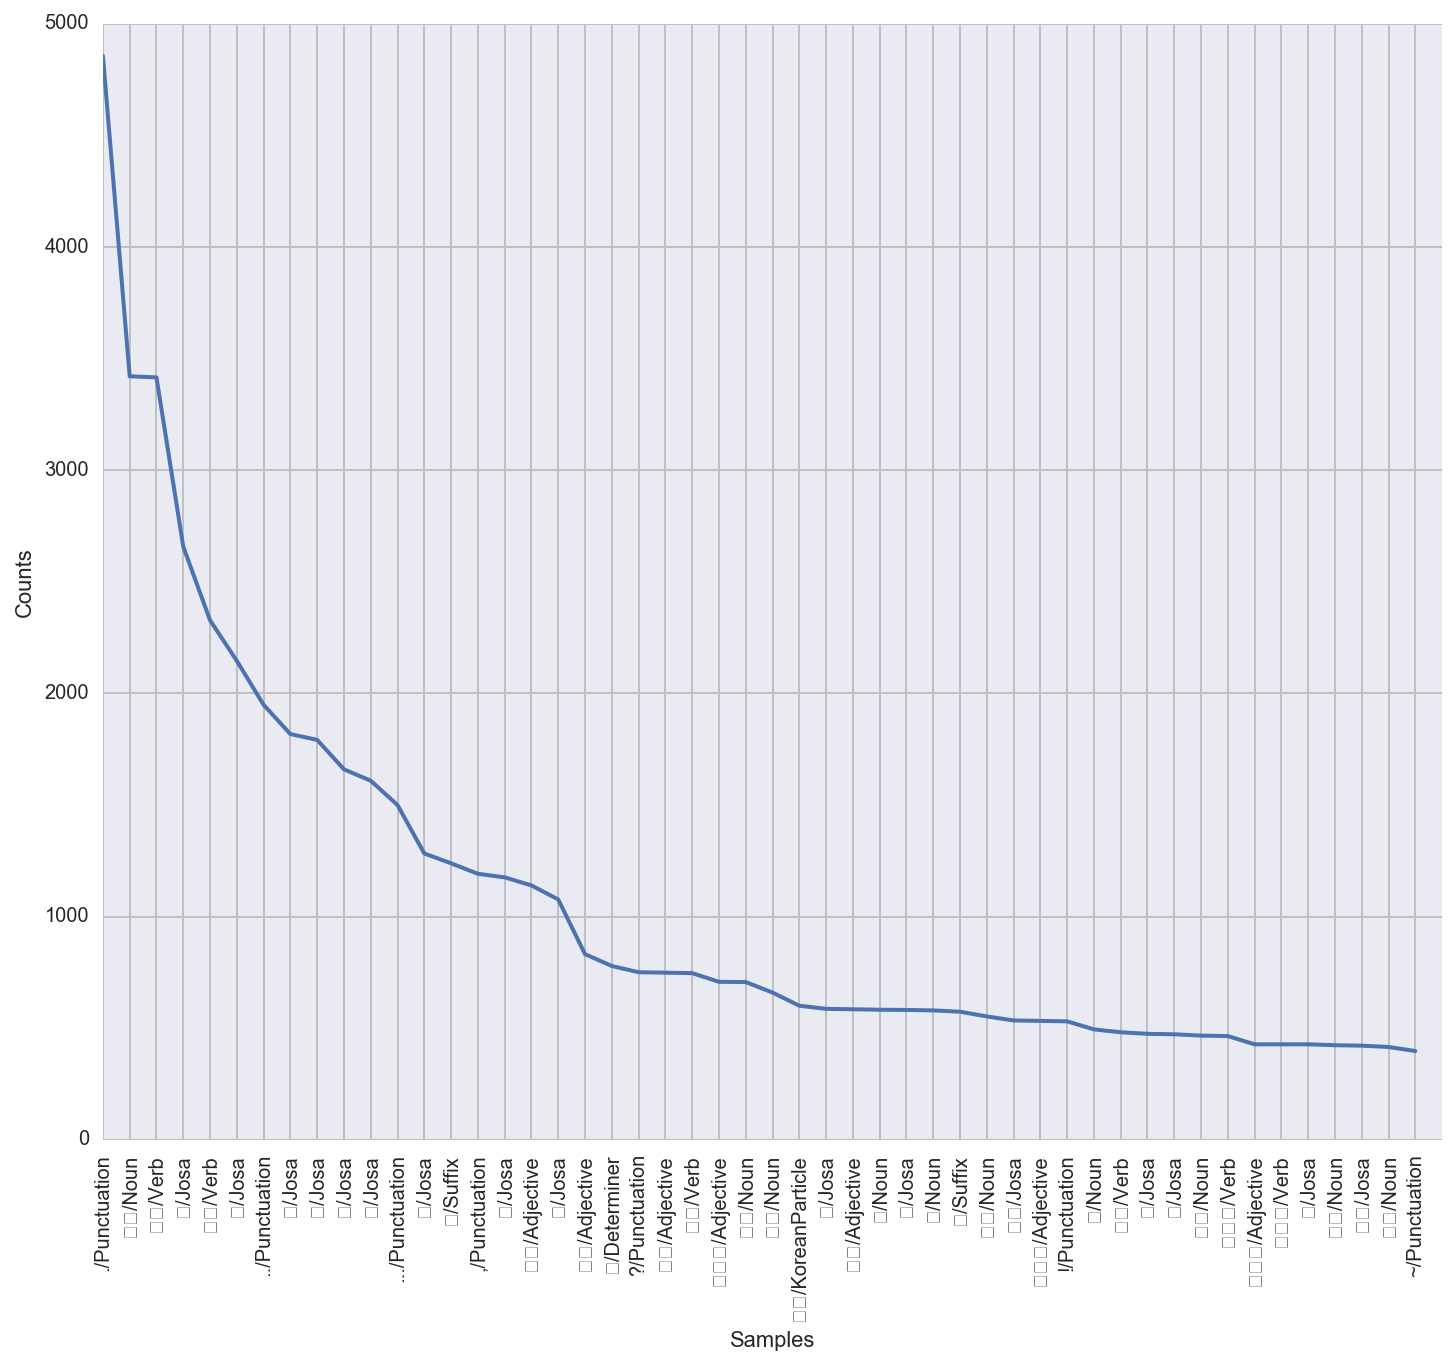

In [123]:
def tokenize(doc):
    return ['/'.join(t) for t in pos_tagger.pos(doc, norm=True, stem=True)]

train_docs = [(tokenize(row[1]), row[2]) for row in train_data[:10000]]

tokens = [t for d in train_docs for t in d[0]]
import nltk
text = nltk.Text(tokens, name='NMSC')
# mpl.rcParams["font.family"] = "NanumGothic"
mpl.rcParams["font.family"] = "sans-serif"
plt.figure(figsize=(12,10))
text.plot(50)
plt.show()